# Integer minimum cost flows with separable convex cost objective

The Problem of finding the most likely mulitpath split for a payment pair on the lightning network can be reduced to an **integer minimum cost flows with separable convex cost objective** and yields a polynomial solver c.f.: https://twitter.com/renepickhardt/status/1385144337907044352

This notebook tries to implement a solution given in the Textbook Network Flows Network Flows: Theory, Algorithms, and Applications by Ravindra K. Ahuja, Thomas L. Magnanti and James B. Orlin

This approach follows mainly chapter 9, 10.2 and 14.5 of the Textbook. 

Other good resources are the Lecture series http://courses.csail.mit.edu/6.854/20/ by David Karger (http://people.csail.mit.edu/karger/) with lecture notes at http://courses.csail.mit.edu/6.854/current/Notes/ and more specificially http://courses.csail.mit.edu/6.854/current/Notes/n09-mincostflow.html and the relevant subset of the recorded videos at this playlist: https://www.youtube.com/playlist?list=PLaRKlIqjjguDXlnJWG2T7U52iHZl8Edrcv

Other good resources are the lecture nodes by Hochbaum: https://hochbaum.ieor.berkeley.edu/

I did not find an open source implementation. Code for similar problems seems to be part of this library: https://github.com/frangio68/Min-Cost-Flow-Class but it seems to only allow quadratic cost functions. 

Following previous research ( https://arxiv.org/abs/2103.08576 ) our cost function is f(x) = log(c) - log(c-x) which turns out to be convex (f'(x) = 1/(c-x) and f"(x) = 1/(c-x)^2 from which we can see that f"(x) > 0)

## Donate to this project and work

If you look at the result a probability of 65% to deliver 11 onions with a total sum of 92mBTC is crazy in comparision to how many attempts we currently need. This is what I call an unfair competitive advantage. While I could have created a company and sell the technology to exchanges and payment providers I have decided to open source it because I think knowledge should be open. So if you think this increases the value of the Lightning Network or Bitcoin and if this proved to be useful for you please consider a donation to `bc1qw8220g7wwv7y0kr0chfmgp9shkkqz7kutlnzyf` if you want me to have more time to tinker about issues you could also opt to become a monthly patreon to support my work at: https://www.patreon.com/renepickhardt

For a bit more context of why your donation makes a difference look here: https://twitter.com/renepickhardt/status/1398248328798801921

In [419]:
import json
import networkx as nx
import math

log = math.log2

## some helpers for graphs

introduce some helper functions for handling graphs and importing out data structure / example

In [420]:
def cost(a,c):
    """returns the negative log probability for the success to deliver `a` satoshis through a channel of capacity `c`"""
    #if c%2==0:
    #    return a**2
    #else:
    #    return 4*a**2
    return log(c+1)-log(c+1-a)    

def import_channel_graph():
    """
    parses the channel_graph from the c-lightning API. one coule just create a different function here to parse
    data from other implementations
    """
    # retrieve this by: lightning-cli listchannels > listchannels.json
    f = open("listchannels.json")
    jsn = json.load(f)
    G = nx.DiGraph()
    for channel in jsn["channels"]:
        src = channel["source"]
        dest = channel["destination"]
        #we divide capacities by 10000 to for quicker computation. 
        #This means that we will only approximate the optimal solution 
        cap = int(int(channel["satoshis"])/10000)
        sid = channel["short_channel_id"]
        #FIXME: this will ignore multiedges on the lightning network and assume just a graph without parallel channels
        #for our proof of concept this is ok However the augment_path function currently assumes that the residual
        # network has at most two edges in one direction per node pair which means that no multi edges are supported
        # fixing this is an engineering challange of handeling data and not a problem for the algorithm
        # Thus for better understandability we made the assumption of a graph without parallel channels at this point.
        
        if G.has_edge(src,dest)==False and G.has_edge(dest,src)==False:
            G.add_edge(src,dest,cap=cap,sid=sid,cost=cost)
            G.add_edge(dest,src,cap=cap,sid=sid,cost=cost)
        
        
    return G

def add_fees(G):
    f = open("listchannels.json")
    jsn = json.load(f)
    for channel in jsn["channels"]:
        src = channel["source"]
        dest = channel["destination"]
        b = int(channel["base_fee_millisatoshi"])
        r = int(channel["fee_per_millionth"])
        if G.has_edge(src,dest):
            G[src][dest]["r"]=r
            G[src][dest]["b"]=b
            
def next_hop(path):
    for i in range(1,len(path)):
        src = path[i-1]
        dest = path[i]
        yield (src,dest)
        
def path_str(path):
    it = path[0]
    if len(it)>5:
        it = it[:5]
    res = it
    for src, dest in next_hop(path):
        if len(dest)>5:
            dest = dest[:5]
        res += " {}".format(dest)
    return res

def print_residual(r,G,x):
    for i,j in G.edges():
        cap = G[i][j]["cap"]
        f = x[i][j]
        if r.has_edge(i,j):
            print(i,j,r[i][j])
        if r.has_edge(j,i):
            print(j,i,r[j][i])   

            


In [421]:
def generate_null_flow(G):
    flow = {n:{} for n in G.nodes()}
    for u,v in G.edges():
        flow[u][v]=0
        flow[v][u]=0
    return flow



## The actual implementation of the min cost flow solver for a convex cost function

it consists of 4 helper functions: 

* `compute_delta_residual_network(G,x,delta,pi,C=cost):`
* `fulfill_reduced_cost_optimiality_rule(R,x,e,delta):`
* `augment_path(flow,path,amt,R):`
* `recompute_reduced_cost(R,pi):`

which are used in the actuall api call `capacity_scaling_min_cost_flow(s,d,U,G):`


In [422]:
def add_residual_edges(i,j,G,x,delta,pi,R):
    if G.has_edge(i,j)==False:
        return
    cap = G[i][j]["cap"]
    f = x[i][j]
    C = G[i][j]["cost"]
    if f+delta <=cap:
        unit_cost = (C(f + delta, cap) - C(f,cap))/delta
        R.add_edge(i,j,uc= unit_cost,rc = unit_cost - pi[i] + pi[j],original_cap=cap)#,key=0,k=0)
        #print(unit_cost - pi[i] + pi[j])
    if delta <= f:#backward flow is possible
        unit_cost = (C(f - delta, cap) - C(f,cap))/(delta)
        R.add_edge(j,i,uc= unit_cost,rc=unit_cost - pi[j] + pi[i],original_cap=cap)
        #print(unit_cost - pi[j] + pi[i])

In [465]:
def compute_delta_residual_edge(src,dest,G,x,delta,pi,R):
    while R.has_edge(src,dest):
        R.remove_edge(src,dest)
    while R.has_edge(dest,src):
        R.remove_edge(dest,src)
    
    if x[dest][src]<1:
        add_residual_edges(src,dest,G,x,delta,pi,R)
    if x[src][dest]<1:
        add_residual_edges(dest,src,G,x,delta,pi,R)

In [466]:
def compute_delta_residual_network(G,x,delta,pi,inDelta=False):#,C=cost):
    """
    The delta residual network is returned as a multigraph. 
    
    Note that the delta residual network can be seen as a uni-capacity network. 
    This means that if an edge is in the residual network we can flow delta in the actual network
    and otherwise we can't. 
    As the delta residual network only cares about reduced cost the fuction also gets the potentials passed

    For convenience a bit more information is stored as attributes on the edges:
    uc = unit cost to deliver 1 unit in the delta phase
    rc = reduced cost after aplying potentials
    original_capacity = the capacity of the edge in the original network
    """
    
    residual = nx.MultiDiGraph()
    for i, j in G.edges():
        add_residual_edges(i,j,G,x,delta,pi,residual)
    return residual

In [474]:
def fulfill_reduced_cost_optimiality_rule(R,x,e,delta,G,pi):
    """
    saturates edges non optimal edges in the delta residual network
    
    This is achieved by by:
     - adding or removing delta to the flow `x` of the non optimal edge
     - saturating the flow value of the edge in the delta-residual network `R`
     - changing excesses (suply and demand) of the respeciting nodes to conserve the original flow
    """
    to_remove=set()
    for i,j,k in R.edges(keys=True):
        if R[i][j][k]["rc"] < 0:

            cap = R[i][j][k]["original_cap"]
            # we can remove flow from the edge as the backward flow was larger than delta
            if x[j][i]>=delta:
                x[j][i]-=delta

            # The following two conditions are probably never met unless we allow negative cost 
            # we can add flow in the forward direction as the original capacity is not saturated yet
            elif x[i][j]+delta <= cap:
                x[i][j]+=delta
                #print("forward edge not optimal")
                
            else:
                raise Exception("Negative reduced cost detected but not fixable given delta: {} cap: {} and f: {}".format(delta,R[i][j][k]["original_cap"],max(x[i][j],x[j][i])))
            
            to_remove.add((i,j))
            #adopting the excess values
            e[i]-=delta
            e[j]+=delta
    
    for i,j in to_remove:
        compute_delta_residual_edge(i,j,G,x,delta,pi,R)

In [475]:
def augment_path(flow,path,amt,R,pi,G,C=cost):
    """ augments a given flow with an additional amount amt along some path P
    
    the residual network is necessary as we also need to saturate or 
    """
    for src,dest in next_hop(path):
        if flow[dest][src]>0:
            flow[dest][src]-=amt
        else:
            flow[src][dest]+=amt

        compute_delta_residual_edge(src,dest,G,flow,amt,pi,R)

In [476]:
def recompute_reduced_cost(R,pi):
    """
    helper function to update the reduced costs after potentials have changed
    
    will be called after augmenting every path
    """
    
    for i,j,k in R.edges(keys=True):
        rc = R[i][j][k]["uc"]-pi[i]+pi[j]
        R[i][j][k]["rc"]=rc
        if R[i][j][k]["rc"] < 0:
            print("!!!!",i,j,k,rc)

In [477]:
def print_R(R):
    for src,dest,data in R.edges(data=True):
        print(src,dest,data)

In [478]:
def capacity_scaling_min_cost_flow(s,d,U,G):
    """ 
    returns the min cost flow computed via the capacity scaling algorithm for a convex cost functions
    
    s: is the source node
    d: is the destination or sink
    U: is the amount of flow to be sent
    G: is the graph of which s and d must be elements of    
    """
    
    #set up the flow data structure
    x = generate_null_flow(G)
    
    #initialize excess data structure in particular set supply and demand of source and sink nodes
    e = {n:0 for n in G.nodes}
    e[s]=U
    e[d]=-U
    delta = 2**int(log(U))
    total_cnt=0
    pi = {n:0 for n in G.nodes}
    #It seems indeed as if we do not need to reset potentials in every delta scaling phase but rather keep them
    while delta >= 1:
        #print(pi)
        
        R = compute_delta_residual_network(G,x,delta,pi)
        
        #print_R(R)
        #print("DEBUG!!!",pi["D"]-pi["B"])
        #We saturate edges in the residual network if the reduced cost optimalitiy test fails and modify the flow and excess values
        fulfill_reduced_cost_optimiality_rule(R,x,e,delta,G,pi)
        #fulfill_reduced_cost_optimiality_rule(R,x,e,delta,G,pi)
        #fulfill_reduced_cost_optimiality_rule(R,x,e,delta,G,pi)
        
        #compute the set of source and sink nodes for augmenting paths
        S = [n for n,k in e.items() if k>=delta]
        T = [n for n,k in e.items() if k<=-delta]
                
        #start augmenting paths this is the expensive part of the algorithm
        cnt = 0
        #pi = {n:0 for n in G.nodes}

        while len(S) >0 and len(T)>0:
            print("|S(delta)|={} |T(delta)|={}".format(len(S),len(T)))
            
            #select and arbitrary source and sink node for augmenting paths. 
            #since it is arbitrary we can just take the last element in each set 
            k=S[-1]
            l=T[-1]
            
            #the source might not have any liquid channels in this delta phase 
            if k not in R:
                S.remove(k)
                continue
                
            #compute shortest paths on the reduced cost in the unsaturated delta residual network
            #print(k)
            #print(x)
            #print_R(R)
            #no = True
            for i,j,key in R.edges(keys=True):
                if R[i][j][key]["rc"]<0:
                    print(i,j, R[i][j][key]["rc"])
            distances, paths = nx.single_source_dijkstra(R,k,weight="rc")
            
            #the following is needed in case the residual network is not connected 
            #for the algorithm we just need any shortes path so we can find one in our connected component
            idx =-1
            while l not in paths:
                idx -=1
                
                if (abs(idx)>len(T)):
                    break
                l=T[idx]
            if (abs(idx)>len(T)):
                S.remove(k)
                continue

            path = paths[l]
            # on the selected path for augmentation change the potentials of all nodes acording to the shortest distance 
            # from the source of the augmented path. This will maintain the optimality of reduced cost in future rounds 
            for n, d_value in distances.items():
                pi[n]-=d_value
            
            #TODO: make sure order of the following two calls does in deed not matter
            #with a better data structure this could happen very wellwith in one function call instead of two
            
            
            augment_path(x,path,delta,R,pi,G)
            recompute_reduced_cost(R,pi)
            
            for i in x.keys():
                for j in x[i].keys():
                    if x[i][j]>0 and x[j][i]>0:
                        print("ERROR")
            
            #print("augment: ", delta, path_str(path))
            print("augmented path:", path_str(path), "with:", delta)
            e[k]-=delta
            e[l]+=delta
            
            #TODO: instead of doing this globaly move this to every edge in augmentation
            #R = compute_delta_residual_network(G,x,delta,pi,True)
            #fulfill_reduced_cost_optimiality_rule(R,x,e,delta)
            
            # technically we would not have to recompute S and T but we could just remove the items if the exess and demant are fullfiled
            S = [n for n,k in e.items() if k>=delta]
            T = [n for n,k in e.items() if k<=-delta]
            cnt+=1
        total_cnt+=cnt
        print("augmented {} paths in the {}-scaling phase and {} paths in total".format(cnt,delta,total_cnt))
        delta = int(delta/2)
    return x

## Some examples calls
the first of the example graph and the second one on the lightning network

In [479]:
E = nx.DiGraph()
E.add_edge("S","A",cap=2, cost=cost)
E.add_edge("A","S",cap=2, cost=cost)
E.add_edge("S","X",cap=1, cost=cost)
E.add_edge("X","S",cap=1, cost=cost)
E.add_edge("A","B",cap=2, cost=cost)
E.add_edge("B","A",cap=2, cost=cost)
E.add_edge("X","B",cap=9, cost=cost)
E.add_edge("B","X",cap=9, cost=cost)
E.add_edge("X","Y",cap=7, cost=cost)
E.add_edge("Y","X",cap=7, cost=cost)
E.add_edge("Y","D",cap=4, cost=cost)
E.add_edge("D","Y",cap=4, cost=cost)
E.add_edge("B","D",cap=4, cost=cost)
E.add_edge("D","B",cap=4, cost=cost)

x = capacity_scaling_min_cost_flow("S","D",2,E)
print(x)
print("probability:",2**(-compute_cost(E,x)))


|S(delta)|=1 |T(delta)|=1
augmented path: S A B D with: 2
augmented 1 paths in the 2-scaling phase and 1 paths in total
|S(delta)|=2 |T(delta)|=2
!!!! D B 0 -2.220446049250313e-16
augmented path: Y X B D with: 1
|S(delta)|=1 |T(delta)|=1
D B -2.220446049250313e-16
augmented path: X Y D B with: 1
augmented 2 paths in the 1-scaling phase and 3 paths in total
{'S': {'A': 1, 'X': 1}, 'A': {'S': 0, 'B': 1}, 'X': {'S': 0, 'B': 0, 'Y': 1}, 'B': {'A': 0, 'X': 0, 'D': 1}, 'Y': {'X': 0, 'D': 1}, 'D': {'B': 0, 'Y': 0}}
probability: 0.1244444444444445


In [480]:
E = nx.DiGraph()
E.add_edge("S","A",cap=1, cost=cost)
E.add_edge("S","B",cap=1, cost=cost)
E.add_edge("S","C",cap=1, cost=cost)
E.add_edge("S","D",cap=1, cost=cost)
E.add_edge("S","E",cap=1, cost=cost)
E.add_edge("A","T",cap=1, cost=cost)
E.add_edge("B","T",cap=1, cost=cost)
E.add_edge("C","T",cap=1000, cost=cost)
E.add_edge("D","T",cap=1, cost=cost)
E.add_edge("E","T",cap=1, cost=cost)
E.add_edge("A","C",cap=1000, cost=cost)
E.add_edge("B","C",cap=1000, cost=cost)
E.add_edge("D","C",cap=1000, cost=cost)
E.add_edge("E","C",cap=1000, cost=cost)


x = capacity_scaling_min_cost_flow("S","T",5,E)
print(x)
print("probability:",2**(-compute_cost(E,x)))
pi = {n:0 for n in E.nodes}
R = compute_delta_residual_network(E,x,1,pi)
if nx.negative_edge_cycle(E,weight="rc"):
    print("min cost flow not optimal")
else:
    print("min cost flow was optimal")


x = generate_null_flow(E)
x["S"]["A"]=1
x["S"]["B"]=1
x["S"]["C"]=1
x["S"]["D"]=1
x["S"]["E"]=1
x["A"]["C"]=1
x["B"]["C"]=1
x["D"]["C"]=1
x["E"]["C"]=1
x["C"]["T"]=5

print("probability:",2**(-compute_cost(E,x)))

|S(delta)|=1 |T(delta)|=1
augmented 0 paths in the 4-scaling phase and 0 paths in total
|S(delta)|=1 |T(delta)|=1
augmented 0 paths in the 2-scaling phase and 0 paths in total
|S(delta)|=1 |T(delta)|=1
augmented path: S C T with: 1
|S(delta)|=1 |T(delta)|=1
augmented path: S A C T with: 1
|S(delta)|=1 |T(delta)|=1
augmented path: S B C T with: 1
|S(delta)|=1 |T(delta)|=1
augmented path: S D C T with: 1
|S(delta)|=1 |T(delta)|=1
augmented path: S E C T with: 1
augmented 5 paths in the 1-scaling phase and 5 paths in total
{'S': {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1}, 'A': {'S': 0, 'T': 0, 'C': 1}, 'B': {'S': 0, 'T': 0, 'C': 1}, 'C': {'S': 0, 'A': 0, 'B': 0, 'T': 5, 'D': 0, 'E': 0}, 'D': {'S': 0, 'T': 0, 'C': 1}, 'E': {'S': 0, 'T': 0, 'C': 1}, 'T': {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 0}}
probability: 0.03096984078779992
min cost flow was optimal
probability: 0.03096984078779992


In [481]:
channel_graph = import_channel_graph()
add_fees(channel_graph)
SRC = "03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df"
DEST = "022c699df736064b51a33017abfc4d577d133f7124ac117d3d9f9633b6297a3b6a"
FLOW = 920

from timeit import default_timer as timer

start = timer()
x = capacity_scaling_min_cost_flow(SRC,DEST,FLOW, channel_graph)
end = timer()
print("comutation took {} seconds".format(end - start)) 


|S(delta)|=1 |T(delta)|=1
augmented path: 03efc 03267 022c6 with: 512
augmented 1 paths in the 512-scaling phase and 1 paths in total
|S(delta)|=759 |T(delta)|=124
augmented path: 029fd 02616 0260f 037f9 02dfd 03c9b 021c9 03864 03cde 030c3 03bec with: 256
|S(delta)|=759 |T(delta)|=124
augmented path: 029fd 03005 0284a 0390b 033d8 0242a 02e90 03864 021c9 03c9b 02dfd 037f9 0260f 02616 03abf 037cc 03baa 030c3 03bec with: 256
|S(delta)|=758 |T(delta)|=123
augmented path: 0215a 03271 03d06 021c9 03864 02bd2 02d41 0296d with: 256
|S(delta)|=757 |T(delta)|=123
!!!! 0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 0355415c9a1ad65ac3033b00d78046d726131f15c5e1ead353ea6f801cb9b40e33 0 -6.938893903907228e-18
augmented path: 0215a 03baa 02bd2 03864 02651 02d41 0296d with: 256
|S(delta)|=756 |T(delta)|=122
0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 0355415c9a1ad65ac3033b00d78046d726131f15c5e1ead353ea6f801cb9b40e33 -6.938893903907228e-18
!!!! 037c8d28484c285d

!!!! 02bffed43c1e140263150c81cad301e4b3ba2c3d21cdb012cd49252fd52b714a6e 02c87ddac0fb9ddbcc88557275419dd9a307275eabe9d2f74e338d90b0eda81be7 0 -3.469446951953614e-18
!!!! 02d6647db36045d6652431a57bd3ed49cd1397100d0a2f08c60691ba51c80f77ea 028488b6e7f80c53cb727bd87fa3679b6ad0d6647aaf664d17884d45f30e8d9c61 0 -6.938893903907228e-18
!!!! 0296df4dbdb47942379a78cf541364cd9acb9518989500270b93549f4f95b11ffb 02d419c9af624d0e7a7c90a60b9ffa35f4934973a9d7d3b4175cc3cc28b7ffcde1 0 -0.01201706414349231
augmented path: 029f0 02529 033d8 0288b 021c9 with: 256
|S(delta)|=748 |T(delta)|=118
03271338633d2d37b285dae4df40b413d8c6c791fbee7797bc5dc70812196d7d5c 02e562ab30e0ca1a2a72d6004e8aaffeb449fe9c0cb2d9be0e8e1497709b899784 -6.938893903907228e-18
036b9a856dd196180fd0b71a0ba63ad53be0e4db4faf2c4e4133f1c287f3a6ee97 02f63f49339c8b438c3291ab21e35d1b5642ac2360240068b5ecd3fd5183f2c042 -6.938893903907228e-18
03f57da433d006dd13446b760721c7e9d13bdc8e4f9c1bc402f30084833f21c4dd 038b0e5d711f3112e6b0ffd2b6d0ae90977a0b5eb30

!!!! 03d06758583bb5154774a6eb221b1276c9e82d65bbaceca806d90e20c108f4b1c7 02bf187357baa624c178c24b08a15825dc059b7d7c02695ea9f1e2400952e5fc7d 0 -6.938893903907228e-18
!!!! 03d06758583bb5154774a6eb221b1276c9e82d65bbaceca806d90e20c108f4b1c7 03ad156742a9a9d0e82e0022f264d6857addfd534955d5e97de4a695bf8dd12af0 0 -6.938893903907228e-18
!!!! 03d06758583bb5154774a6eb221b1276c9e82d65bbaceca806d90e20c108f4b1c7 03713459928efee7e06945dd36d0f256c8e22941dcaf9861039a18cd040f53c887 0 -6.938893903907228e-18
!!!! 03d06758583bb5154774a6eb221b1276c9e82d65bbaceca806d90e20c108f4b1c7 03094b63a5ece2c363ab859952017f95bec7bd9e6975f0c8152f9eff83d0b045c2 0 -6.938893903907228e-18
!!!! 03f51df0183b2083d678d867d7441ba7e8dbf1bfdd23729d702b81a8b128e3e876 02f376b02d3a82aaad471ccdeb060817843aef5b77b029d79d31c94b27cb66bcb6 0 -6.938893903907228e-18
!!!! 03bec3989098df0675033530169ef105b1bd3be8fd989cb7955cb4b59616ab3530 02aa6d04033505013665f96f31c097233947e7cc294558f32036a2f9988567c3e1 0 -6.938893903907228e-18
!!!! 022755c3ff4

034ea80f8b148c750463546bd999bf7321a0e6dfc60aaf84bd0400a2e8d376c0d5 036533303d73c34c58c35017cc286da18b5958a14ceed21f1d419eb818942e3698 -6.938893903907228e-18
034ea80f8b148c750463546bd999bf7321a0e6dfc60aaf84bd0400a2e8d376c0d5 031ec84234e6abe4930fabaf04c92776fadc8fa0b6cd9b48dfab280f1366d461aa -6.938893903907228e-18
034ea80f8b148c750463546bd999bf7321a0e6dfc60aaf84bd0400a2e8d376c0d5 0366d8a3608b352daca0d29c6c0ca464be81bef261153339b2571da8e1f7ff8228 -6.938893903907228e-18
034ea80f8b148c750463546bd999bf7321a0e6dfc60aaf84bd0400a2e8d376c0d5 0379e31eb521ca395e4e0b42d4fff1985408f5e670085c3beaafa7260f1efcbe84 -6.938893903907228e-18
03d6b14390cd178d670aa2d57c93d9519feaae7d1e34264d8bbb7932d47b75a50d 023662f1db3d0527dab0869e30f183021db7dc44f6f2e32ece42dd124846c89ca1 -6.938893903907228e-18
02043b4834a867fd8787c9878bace14310318f8622ed1b195e8d2aca2e49499dd5 03dd15edf1f0adf9cfd2a79654e600e96b39ef4a2fa9e875a5377ba4da953a7f37 -3.469446951953614e-18
02738dff8dddf9577b85d48094d0a01259f7a45b687e0ad908b92ed281

02b0172bb38617fa3afdb69664468b492d5a21062a4fa8b47284b0cc320e6e7420 0216a63a63e14ed9f6c9369f9951105dab791644b8496c5531877b3120be8c947b -6.938893903907228e-18
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 035c7735413cb1fa92f8bfa3406c7f89a6ff31a93c72bb558da11d8b52d51fa47d -6.938893903907228e-18
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 02f0c9ba2df10171326a77518f8f5f5708677efa0656f377e8256d71f8f8df433a -6.938893903907228e-18
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 03142b162b4e55237e49dc8aadf919c99eface419c21869339687f365c93675886 -6.938893903907228e-18
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 02ee8c98a78d8061f6c9c09a9b36b05e02e03736609ea5e5eb8afdcd7f7163c50f -6.938893903907228e-18
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 03e26a98ee4d1320d5775fab291580969180592db3679e6d32e360dbd147066ca3 -6.938893903907228e-18
033e9ce4e8f0e68f7db49ffb6b9eecc10605f3f3fcb3c630545887749a

!!!! 03d37fca0656558de4fd86bbe490a38d84a46228e7ec1361801f54f9437a18d618 02c1f09ec838d3125c9ac39bcdb0e71e272f7cd11fb0e4c8daa920df2ec119eb80 0 -6.938893903907228e-18
!!!! 03abf6f44c355dec0d5aa155bdbdd6e0c8fefe318eff402de65c6eb2e1be55dc3e 03357c64c975934aba80cdc4dc23e565dcab2210143d3186e6b05d460365d8675a 0 -6.938893903907228e-18
!!!! 0303a518845db99994783f606e6629e705cfaf072e5ce9a4d8bf9e249de4fbd019 0364b672df6939e97f63b25c97c12ac59a77a7d1b14383c6a479e1da1e6d29f4c4 0 -6.938893903907228e-18
!!!! 0303a518845db99994783f606e6629e705cfaf072e5ce9a4d8bf9e249de4fbd019 0202ef7315318e7e6706a6eee025f0b150cc7288e273d4b6c494031a7ee94fd143 0 -6.938893903907228e-18
!!!! 03c0b3735592fec56f6a6b678d019d307b4570fd5f4d17ea02858c1e82e6aefe65 02b4f019af3b3fa23681c4cfd81f3031e100d2a2d395f0c9e7924de0a6f9f1079f 0 -6.938893903907228e-18
!!!! 02816caed43171d3c9854e3b0ab2cf0c42be086ff1bd4005acc2a5f7db70d83774 02a2d7bd80ef214d967ed87dd4e613f6f10f5c47a4bf07fe8ec831b2c842a27c53 0 -6.938893903907228e-18
!!!! 02816caed43

!!!! 03fab7f8655169ea77d9691d4bd359e97782cb6177a6f76383994ed9c262af97a5 039cba55635b36d2925cbb8ef8f5f96152602ee73cbe678ed84533eae6a2977692 0 -6.938893903907228e-18
!!!! 03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f 0214b1f6b48998b9eb19d8a756af39a027202cecfe608450109465bbccf3bb74ed 0 -6.938893903907228e-18
!!!! 03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f 03989795ca922d9ff4b580d2b92f5e9522c824c458d54e51a50977f57175690fff 0 -6.938893903907228e-18
!!!! 02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b 037074e315ade887ac91d7156a6ba9962ccf120c124ba9a9051b0bc7a8e36b76d7 0 -6.938893903907228e-18
!!!! 02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b 033ee191b1a33ac9c81b38450b5d7a5bff4bc46933aa5f66bc35027e4121880649 0 -6.938893903907228e-18
!!!! 02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b 03527fd98d029994a0dfbf8be345fd44e741963ad67e26f977500187893b019b22 0 -6.938893903907228e-18
!!!! 02ad6fb8d69

!!!! 032434517e28f7b51665a525d5e11fa493bd4e30a59883b8156c2be4085f4aaf70 02e8dec9b8449d78c64764717d36f05f30057f817895d56dc487b5972832d815ce 0 -6.938893903907228e-18
!!!! 0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 0352e509553ddd100db18d79128eac9de8650ace3061462f0f178ad0540714bde8 0 -6.938893903907228e-18
!!!! 0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 021893db301f95d4def153b160f5dad570f7c9efe347a0de89afb6d6a1aa968784 0 -6.938893903907228e-18
!!!! 0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 02d6c6aefb482b7aeff5a58e9eeda9646093634f8d3cd41dfeb739bd270e38542e 0 -6.938893903907228e-18
!!!! 02bb24da3d0fb0793f4918c7599f973cc402f0912ec3fb530470f1fc08bdd6ecb5 0251fff168b58b74e9b476af5a515b91fe0540a3681bc97fbb65379a807aea5f66 0 -6.938893903907228e-18
!!!! 022c260f9ad58196af280c80a96ec9eabf6404df59ff1a7553b0f381c875a29ba0 02d3d4957a02b2c5d245915d60400ad21cfb47c1b37a0dae0b4f4af1cde96e1f26 0 -6.938893903907228e-18
!!!! 022c260f9ad

!!!! 0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 02c6c35635b659fec9c5e23c852320216765e9c944cbd17daf66c494f039706b66 0 -6.938893903907228e-18
!!!! 0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 021b0a1ce2dbae6f8c5e1adcef7b9025038266f5ebc53240e6066b7277d34e19f6 0 -6.938893903907228e-18
!!!! 0390b5d4492dc2f5318e5233ab2cebf6d48914881a33ef6a9c6bcdbb433ad986d0 034a1a1c49d1cbc31d706275fbf8e396d51466fcd113eb5335742ad3f99447cfc9 0 -6.938893903907228e-18
!!!! 0390b5d4492dc2f5318e5233ab2cebf6d48914881a33ef6a9c6bcdbb433ad986d0 03fafcd7745aa24e662ca22de88b1d208865dd46496cbbdc9115594a2d5c2c3b7c 0 -6.938893903907228e-18
!!!! 0242a4ae0c5bef18048fbecf995094b74bfb0f7391418d71ed394784373f41e4f3 030fe1e426098d3f9423f18ce6aeda899672985e8ffdb13d84e85e16eb48a53c74 0 -6.938893903907228e-18
!!!! 0242a4ae0c5bef18048fbecf995094b74bfb0f7391418d71ed394784373f41e4f3 025d780b5d74120847aefe384e2b4a733667743d621a9eadabe661f76ca5d23d7f 0 -6.938893903907228e-18
!!!! 0242a4ae0c5

!!!! 0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266 029602768fc5162f3e25e568190a76e13a782fa941c76aae1d3df56a93ccdce213 0 -6.938893903907228e-18
!!!! 03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6 02bfb576be997eac8afbf6fb22e8e69b58eaea2640f6aab6b7ba3f54ca5adf49f4 0 -6.938893903907228e-18
!!!! 03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6 029799e356f54bceda8ceaaeee3d75a384272307ef3f0829831caa6de2158d1533 0 -6.938893903907228e-18
!!!! 03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6 021733c0bdfd65b361604b8ef5a6c6b07c0c8a26617c3188d1d72d86826473c3ee 0 -6.938893903907228e-18
!!!! 03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6 0266e2d4f645b5c4bb6c84401fc24a63c86e4790f02f06eed5145a9032766e5358 0 -6.938893903907228e-18
!!!! 03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6 0201c0d730b56ab512e5d1a81d81aa31d82cc27c565d9d7af9703f4f457c1ebd8c 0 -6.938893903907228e-18
!!!! 03cde60a632

!!!! 02004c625d622245606a1ea2c1c69cfb4516b703b47945a3647713c05fe4aaeb1c 02d22df3b3013af15a2da1381bdd76266a9375040a5152b67999ad32a26e6b8a88 0 -6.938893903907228e-18
!!!! 0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 02c6c35635b659fec9c5e23c852320216765e9c944cbd17daf66c494f039706b66 0 -6.938893903907228e-18
!!!! 0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c 021b0a1ce2dbae6f8c5e1adcef7b9025038266f5ebc53240e6066b7277d34e19f6 0 -6.938893903907228e-18
!!!! 02bb24da3d0fb0793f4918c7599f973cc402f0912ec3fb530470f1fc08bdd6ecb5 03093c3867e6b11193c26caa446880319db7d122f8629ed9052965bccd356c24f4 0 -1.3877787807814457e-17
!!!! 02bb24da3d0fb0793f4918c7599f973cc402f0912ec3fb530470f1fc08bdd6ecb5 024f1ab2067e96175e4123f767dd482f58130da802d71a2d1e00871849c3c4dcaa 0 -1.3877787807814457e-17
!!!! 021607cfce19a4c5e7e6e738663dfafbbbac262e4ff76c2c9b30dbeefc35c00643 03fcf9e53678d18e51f0e2da4515caa64c517e3f8cc804809b44ecc165d214b3fd 0 -6.938893903907228e-18
!!!! 021607cfc

!!!! 032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 027e53e6a35c67d1535c89355254841ed82953b7fbbf5d0a554bd8cf4c94575572 0 -6.938893903907228e-18
!!!! 032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 031839321bf3ec55d4225be42219ca9c14b0d87331d1a962667d6f3ce43120f7d6 0 -6.938893903907228e-18
!!!! 032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 0246bf8422ee28ce098f77490d215564fea83cb000de8a9de7953926a4a169f3f1 0 -6.938893903907228e-18
!!!! 03baa70886d9200af0ffbd3f9e18d96008331c858456b16e3a9b41e735c6208fef 0231802089629c66c1fe76da7e161ae50143940c1fe4e10b5252a5c77f4f9e2397 0 -6.938893903907228e-18
!!!! 02004c625d622245606a1ea2c1c69cfb4516b703b47945a3647713c05fe4aaeb1c 0207262fc331c1c845c6f8f7cca7a04ec3bdb09ef82cddac3eda2953c10bddd779 0 -6.938893903907228e-18
!!!! 02004c625d622245606a1ea2c1c69cfb4516b703b47945a3647713c05fe4aaeb1c 024509d6321a579b3f72117509e243d6cdd86874cb0731ff39be6c92f3e64b53a1 0 -6.938893903907228e-18
!!!! 035f5236d7e

!!!! 02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b 03527fd98d029994a0dfbf8be345fd44e741963ad67e26f977500187893b019b22 0 -6.938893903907228e-18
!!!! 02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b 035d89677a2af4b4c7b6905505c9b060f9d7ac572c847fddab1e26301d09802004 0 -6.938893903907228e-18
!!!! 02e9046555a9665145b0dbd7f135744598418df7d61d3660659641886ef1274844 03b90e1857a80833c67b9a3d758cfa795ac3085cb27f587ea0613c200455fcb297 0 -6.938893903907228e-18
!!!! 033d8656219478701227199cbd6f670335c8d408a92ae88b962c49d4dc0e83e025 036d81bb87af589f949dec53af1b3121c84048d0913eb56945cbbb62c5cb4fcb6f 0 -6.938893903907228e-18
!!!! 033d8656219478701227199cbd6f670335c8d408a92ae88b962c49d4dc0e83e025 03e9513e9d06be80a91185d52d1fd654f158508d0bc3de7cc7ed8506bcd3e2fe54 0 -6.938893903907228e-18
!!!! 033d8656219478701227199cbd6f670335c8d408a92ae88b962c49d4dc0e83e025 03f006cd6c04920a63902df45be3baa4e7df82eed9c1e7f46e8441d57199682fa3 0 -6.938893903907228e-18
!!!! 03a503d8e30

!!!! 03fab7f8655169ea77d9691d4bd359e97782cb6177a6f76383994ed9c262af97a5 0232c9cdca608482d3d4990b8b8dabcd6b1a5d09cc3ba6b284a372a037ee26d993 0 -6.938893903907228e-18
!!!! 03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f 0214b1f6b48998b9eb19d8a756af39a027202cecfe608450109465bbccf3bb74ed 0 -6.938893903907228e-18
!!!! 03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f 03989795ca922d9ff4b580d2b92f5e9522c824c458d54e51a50977f57175690fff 0 -6.938893903907228e-18
!!!! 02247d9db0dfafea745ef8c9e161eb322f73ac3f8858d8730b6fd97254747ce76b 02a4c2430e8e826b40cd863a35d2aa97c4d4985367d75fbd713d9bff6c78ba8c7c 0 -6.938893903907228e-18
!!!! 02247d9db0dfafea745ef8c9e161eb322f73ac3f8858d8730b6fd97254747ce76b 03019c7f5bca96909f898986f7a82eb6d4e783785cf496572a3189d1ea20a6e00f 0 -6.938893903907228e-18
!!!! 03f93ded37d70d2e5e30143114bc9f132385d51d196b3bad09ef8e77f950f13903 0211ce12089e45ee7a68d0e94ee60c938c72a5317cc78f9ca456b823378501f3fd 0 -6.938893903907228e-18
!!!! 0340cfadaa3

ValueError: ('Contradictory paths found:', 'negative weights?')

## Test if the result is indeed a min cost flow!
we have a minimum cost flow if the 1Residual net has no negative cycles!

In [ ]:
def compute_cost(G,x):
    total_cost = 0
    for s,d in G.edges():
        c = G[s][d]["cap"]
        f = x[s][d]
        if f > 0:
            total_cost+=G[s][d]["cost"](f,c)
            
    return total_cost

In [ ]:
pi = {n:0 for n in channel_graph.nodes}
R = compute_delta_residual_network(channel_graph,x,1,pi)
if nx.negative_edge_cycle(channel_graph,weight="rc"):
    print("min cost flow not optimal")
else:
    print("min cost flow was optimal")

print("min cost flow has probability: ",2**-compute_cost(channel_graph,x) )

## Some evaluation and nicer depiction of the results

In [14]:
nodes = set()
for src, v in x.items():
    for dest, f in v.items():
        if f>0:
            nodes.add(src)
            nodes.add(dest)

print("Min cost flow of {} from {} to {} includes {} nodes: ".format(FLOW,SRC[:5],DEST[:5],len(nodes)))

print("\nOutflow of source node: ")
total_flow = 0
outprob = 1
for dest,f in x[SRC].items():
    if f>0:
        #cap = 0
        #if channel_graph.has_edge(SRC,dest):
        cap = channel_graph[SRC][dest]["cap"]
        #else: 
        #    channel_graph[DEST][dest]["cap"]
        print(SRC[:5],dest[:5], "flow {} of cap {}: ({:4.2f})".format(f,cap,(cap+1-f)/(cap+1)) )
        total_flow+=f
        outprob*=(cap+1-f)/(cap+1)
print("resulting in total outflow of:", total_flow, "prob: ", outprob)

print("\nInflow at destination node: ")
total_flow = 0
inprob=1
for src, v in x.items():
    for dest, f in v.items():
        if f>0 and dest == DEST:
            cap = channel_graph[src][dest]["cap"]
            print(src[:5],dest[:5], "flow {} of cap {}: ({:4.2f})".format(f,cap,(cap+1-f)/(cap+1)) )
            total_flow+=f
            inprob*=(cap+1-f)/(cap+1)
print("resulting in a total inflow at the destination of: ", total_flow, "prob:", inprob)

print("\nEntire flow: ")
res = 1
for src, v in x.items():
    for dest, f in v.items():
        if f>0:
            nodes.add(src)
            nodes.add(dest)
            cap = channel_graph[src][dest]["cap"]
            print(src[:5], dest[:5],f,"of", cap, "({:4.2f})".format((cap+1-f)/(cap+1)) )
            res*=(cap+1-f)/(cap+1)
            
print("total probability: ", res)
print("with knowledge of local balance at source and destination: ", res/inprob/outprob)

Min cost flow of 1400 from 03efc to 022c6 includes 27 nodes: 

Outflow of source node: 
03efc 03abf flow 42 of cap 700: (0.94)
03efc 02247 flow 610 of cap 1677: (0.64)
03efc 03267 flow 398 of cap 900: (0.56)
03efc 03cde flow 350 of cap 1000: (0.65)
resulting in total outflow of: 1400 prob:  0.21723850130141747

Inflow at destination node: 
03e28 022c6 flow 466 of cap 1677: (0.72)
0390b 022c6 flow 99 of cap 1677: (0.94)
03d37 022c6 flow 88 of cap 1677: (0.95)
03267 022c6 flow 398 of cap 1677: (0.76)
024d2 022c6 flow 73 of cap 900: (0.92)
031ce 022c6 flow 94 of cap 1677: (0.94)
022c2 022c6 flow 109 of cap 1677: (0.94)
02d4b 022c6 flow 73 of cap 1677: (0.96)
resulting in a total inflow at the destination of:  1400 prob: 0.38115959054799875

Entire flow: 
03e28 022c6 466 of 1677 (0.72)
03864 021c9 303 of 30000 (0.99)
03abf 022c2 42 of 1677 (0.97)
03167 02d4b 23 of 1677 (0.99)
03efc 03abf 42 of 700 (0.94)
03efc 02247 610 of 1677 (0.64)
03efc 03267 398 of 900 (0.56)
03efc 03cde 350 of 1000 (

In [22]:
def disect_flow_to_paths(x,s,d):
    G = nx.DiGraph()
    for src, v in x.items():
        for dest, f in v.items():
            if f>0:
                G.add_edge(src,dest,weight=f)
    m = 1
    paths = []
    while m>0:
        try: 
            path = nx.shortest_path(G,s,d)
            m = min(G[src][dest]["weight"] for src, dest in next_hop(path))
            #t+=m
            #print("{} sats along {}".format(m*10000,path_str(path)))
            paths.append((path,m))
            for src,dest in next_hop(path):
                G[src][dest]["weight"]-=m
                if G[src][dest]["weight"]==0:
                    G.remove_edge(src,dest)
        except: 
            break
    return paths
    
paths = disect_flow_to_paths(x,SRC,DEST)
fees = 0
for path,amt in paths:
    path_fees = 0
    for src,dest in next_hop(path):
        #print(amt, channel_graph[src][dest]["b"], int(channel_graph[src][dest]["r"]*amt/100))
        path_fees += channel_graph[src][dest]["b"] + int(channel_graph[src][dest]["r"]*amt/100)
    print("amt: {:8} fees: {:6.2f}    path: {}".format(amt*10000,path_fees/1000,path_str(path)))
    fees +=path_fees
print("with an expected total fee of {} satoshi".format(fees/1000))

amt:  3980000 fees:   1.03    path: 03efc 03267 022c6
amt:   420000 fees:   2.21    path: 03efc 03abf 022c2 022c6
amt:    70000 fees:   0.54    path: 03efc 02247 03e28 022c6
amt:   670000 fees:   0.53    path: 03efc 02247 0390b 022c6
amt:   700000 fees:   0.54    path: 03efc 02247 03d37 022c6
amt:   730000 fees:   0.54    path: 03efc 02247 024d2 022c6
amt:   680000 fees:   0.54    path: 03efc 02247 031ce 022c6
amt:   640000 fees:   0.53    path: 03efc 02247 022c2 022c6
amt:   300000 fees:   6.22    path: 03efc 03cde 02d4b 022c6
amt:   650000 fees:   4.16    path: 03efc 03cde 03d06 03e28 022c6
amt:   910000 fees:   3.10    path: 03efc 02247 02b68 03e28 022c6
amt:    90000 fees:   0.45    path: 03efc 02247 03bc9 0390b 022c6
amt:    50000 fees:   0.44    path: 03efc 02247 0311c 0390b 022c6
amt:    90000 fees:   0.45    path: 03efc 02247 033e9 0390b 022c6
amt:    90000 fees:   0.48    path: 03efc 02247 0284a 0390b 022c6
amt:    50000 fees:   1.47    path: 03efc 02247 0260f 03d37 022c6
amt:

## Simulation in a realistic setting

In [23]:
import random

In [24]:
def initialize_balances(G):
    for s,d in G.edges():
        cap = G[s][d]["cap"]
        bal=int(random.random()*cap)
        G[s][d]["balance"]=bal
        G[d][s]["balance"]=cap - bal

initialize_balances(channel_graph)

In [25]:
def test_onion(amt, path, G):
    for src,dest in next_hop(path):
        if G[src][dest]["balance"]<amt:
            return False
    return True

def update_success_onion(amt,path,G):
    for src,dest in next_hop(path):
        G[src][dest]["cap"]-=amt
        G[src][dest]["balance"]-=amt

def update_failure_onion(amt,path,G):
    for src,dest in next_hop(path):
        if G[src][dest]["balance"]>=amt:
            if amt > G[src][dest]["min_possible"]:
                G[src][dest]["min_possible"]=amt
        else:
            G[src][dest]["cap"]=amt
            break
            


In [44]:

def pay(U, s, d, G,with_routing_hint=False):
    H = G.copy()
    for src,dest in H.edges():
        H[src][dest]["min_possible"] = 0
    zerocost = lambda a,c : 0
    for n in H[s]:
        H[s][n]["cap"]=H[s][n]["balance"]
        H[s][n]["cost"]=zerocost
        H[n][s]["cap"]=H[n][s]["balance"]
        H[n][s]["cost"]=zerocost
    
    if with_routing_hint==True:
        for n,_ in H.in_edges(d):
            H[d][n]["cap"]=H[d][n]["balance"]
            H[d][n]["cost"]=zerocost
            H[n][d]["cap"]=H[n][d]["balance"]
            H[n][d]["cost"]=zerocost
    
    delivered = 0 
    fees = 0
    while delivered !=U:
        x = capacity_scaling_min_cost_flow(s,d,U-delivered, H)
        print("min cost flow to deliver {} has probability: {}".format((U-delivered)*10000,2**-compute_cost(H,x)))
        
        paths = disect_flow_to_paths(x,s,d)
        for path,amt in paths:
            path_fees = 0
            print("{} sats along {}".format(amt*10000,path_str(path)),end=" ")
            if test_onion(amt,path,H)==True:
                print("succeeds")
                update_success_onion(amt,path,H)
                delivered+=amt
                for src,dest in next_hop(path):
                    fees += channel_graph[src][dest]["b"] + int(channel_graph[src][dest]["r"]*amt/100)
            else:
                print("fails")
                update_failure_onion(amt,path,H)
    
    print("with a total fee of {} satoshi".format(fees/1000))
        
    return x

In [45]:
x = pay(4000, SRC,DEST, channel_graph,True)
#H = pay(920, SRC,DEST, channel_graph)


augmented 0 paths in the 2048-scaling phase and 0 paths in total
augmented 0 paths in the 1024-scaling phase and 0 paths in total
augmented 2 paths in the 512-scaling phase and 2 paths in total
augmented 7 paths in the 256-scaling phase and 9 paths in total
augmented 9 paths in the 128-scaling phase and 18 paths in total
augmented 25 paths in the 64-scaling phase and 43 paths in total
augmented 35 paths in the 32-scaling phase and 78 paths in total
augmented 57 paths in the 16-scaling phase and 135 paths in total
augmented 72 paths in the 8-scaling phase and 207 paths in total
augmented 71 paths in the 4-scaling phase and 278 paths in total
augmented 75 paths in the 2-scaling phase and 353 paths in total
augmented 77 paths in the 1-scaling phase and 430 paths in total
min cost flow to deliver 40000000 has probability: 0.011172503119180286
30000 sats along 03efc 0242a 022c6 succeeds
80000 sats along 03efc 02e7c 022c6 succeeds
2770000 sats along 03efc 03267 022c6 succeeds
120000 sats alo

In [42]:
print(sum(channel_graph[SRC][x]["balance"] for x in channel_graph[SRC]))
print(sum(channel_graph[x][DEST]["balance"] for x,_ in channel_graph.in_edges(DEST)))


4234
15962


# WIP code snippets not cleaned up yet

ImportError: requires pygraphviz http://pygraphviz.github.io/

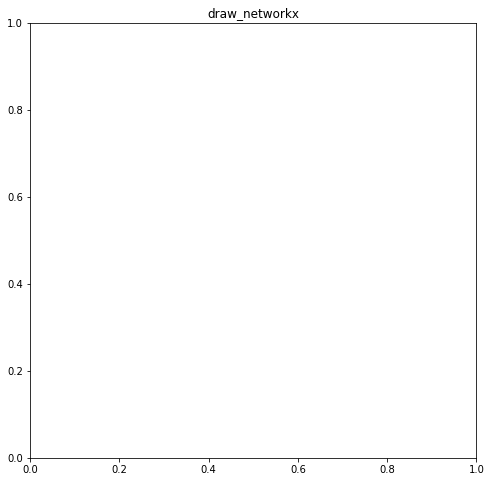

In [261]:
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
#import matplotlib.pyplot as plt
G = nx.DiGraph()
for src, v in x.items():
    for dest, f in v.items():
        if f > 0:
            G.add_edge(src,dest,flow=f)

#for v in G.nodes():
#    G[v]['name']=v[:4]


#all nodes must have subset_key (default='subset') as data (can probably be used as distance in bfs)
#pos = nx.multipartite_layout(G)
fig = plt.figure(figsize=(8,8))

#write_dot(G,'test.dot')

# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos =graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, arrows=True)

pos = nx.spectral_layout(G)
nx.draw(G, pos=pos) 
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
#plt.savefig('this.png')
plt.show()
"""
#nx.draw(G, pos)
node_labels = nx.get_node_attributes(G,'name')
nx.draw_networkx_labels(G, pos, labels = node_labels)
edge_labels = nx.get_edge_attributes(G,'flow')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
#plt.savefig('this.png')
plt.show()"""

In [206]:

x = generate_null_flow(G)
pi = {n:0 for n in G.nodes}
R = compute_delta_residual_network(G,x,2,pi)
print_residual(R,G,x)

x["S"]["A"]=2
x["A"]["B"]=2
x["B"]["D"]=2

"""
pi["S"]-=0
pi["A"]-=R["S"]["A"][0]["rc"]
pi["B"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"]
pi["X"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"] + R["B"]["X"][0]["rc"]
pi["Y"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"] + R["B"]["X"][0]["rc"] + R["X"]["Y"][0]["rc"]
pi["D"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"] + R["B"]["D"][0]["rc"]
"""
print(paths["D"])
distances, paths = nx.single_source_dijkstra(R,"S",weight="rc")
            #distances, paths = nx.single_source_bellman_ford(R,k,weight="rc")
            #####print("Distances from {}".format(k))
for n, d_value in distances.items():
                #####print(n,d_value)
                #if n in pi:
    pi[n]-=d_value

#add hoc because known for our data set
e = {n:0 for n in G.nodes}
print(pi)

print(x)
R = compute_delta_residual_network(G,x,1,pi)
print("\n1-residual network after 2 flow S A B D")
print_residual(R,G,x)

fulfill_reduced_cost_optimiality_rule(R,x,e,1)
print_residual(R,G,x)
r = get_unsaturated_residual_subgraph(R)
print_residual(r,G,x)
print(e)
print(x)

distances, paths = nx.single_source_dijkstra(r,"X",weight="rc")
for n, d_value in distances.items():
                #####print(n,d_value)
                #if n in pi:
    pi[n]-=d_value
path = paths["D"]

R = recompute_reduced_cost(R,pi)

augment_path(x,path,1,R)
r = get_unsaturated_residual_subgraph(R)
print_residual(r,G,x)

distances, paths = nx.single_source_dijkstra(r,"Y",weight="rc")
for n, d_value in distances.items():
                #####print(n,d_value)
                #if n in pi:
    pi[n]-=d_value

path = paths["B"]
augment_path(x,path,1,R)
print(x)

S A {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
A S {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
A B {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
B A {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
X B {0: {'uc': 0.1609640474436811, 'rc': 0.1609640474436811, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 9, 'k': 0}}
B X {0: {'uc': 0.1609640474436811, 'rc': 0.1609640474436811, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 9, 'k': 0}}
X Y {0: {'uc': 0.20751874963942196, 'rc': 0.20751874963942196, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 7, 'k': 0}}
Y X {0: {'uc': 0.20751874963942196, 'rc': 0.20751874963942196, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 7, 'k': 0}}
B D {0: {'uc': 0.36848279708310305, 'rc': 0.36848279708310305, 'flow': 0, 'c

## using graph tool lib to use boost

dijktra search with is our limiting call is according to benchmarks on similar graphs about 110x fast than the networkx dijkstra: (c.f.:

some particularlies are important. removin edges in the residual graph happens quite frequently and should be O(1) instead of O(k_s + k_d) thus we use the set_fast_edge_removal API
https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.Graph.set_fast_edge_removal

we use edge property maps to store edge data https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.EdgePropertyMap


In [49]:
!conda install -y -c conda-forge graph-tool

Solving environment: | 
  - https://repo.continuum.io/pkgs/main/osx-64/bzip2-1.0.6-hd86a083_4.tar.bz2/osx-64::bzip2-1.0.6-hd86a083_4, https://repo.continuum.io/pkgs/main/osx-64/conda-env-2.6.0-h36134e3_0.tar.bz2/osx-64::conda-env-2.6.0-h36134e3_0, https://repo.continuum.io/pkgs/main/osx-64/intel-openmp-2018.0.0-h8158457_8.tar.bz2/osx-64::intel-openmp-2018.0.0-h8158457_8, https://repo.continuum.io/pkgs/main/osx-64/jbig-2.1-h4d881f8_0.tar.bz2/osx-64::jbig-2.1-h4d881f8_0
  - defaults/osx-64::bzip2-1.0.6-hd86a083_4, https://repo.continuum.io/pkgs/main/osx-64/conda-env-2.6.0-h36134e3_0.tar.bz2/osx-64::conda-env-2.6.0-h36134e3_0, https://repo.continuum.io/pkgs/main/osx-64/intel-openmp-2018.0.0-h8158457_8.tar.bz2/osx-64::intel-openmp-2018.0.0-h8158457_8, https://repo.continuum.io/pkgs/main/osx-64/jbig-2.1-h4d881f8_0.tar.bz2/osx-64::jbig-2.1-h4d881f8_0
  - defaults/osx-64::conda-env-2.6.0-h36134e3_0, https://repo.continuum.io/pkgs/main/osx-64/bzip2-1.0.6-hd86a083_4.tar.bz2/osx-64::bzip2-1.0.6-

In [50]:
import graph_tool.all as gt


/Users/rpickhardt/anaconda3/lib/python3.6/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: dlopen(/Users/rpickhardt/anaconda3/lib/python3.6/site-packages/graph_tool/draw/libgraph_tool_draw.so, 9): Library not loaded: @rpath/libsigc-2.0.0.dylib
  Referenced from: /Users/rpickhardt/anaconda3/lib/libcairomm-1.0.1.dylib
  Reason: image not found
  warnings.warn(msg, RuntimeWarning)


In [72]:
idx2nodeid = list(channel_graph.nodes())
nodeid2idx = {n:i for i,n in enumerate(idx2nodeid)}

g = gt.Graph()
start = timer()
g.add_vertex(len(idx2nodeid))
cnt =0
g.add_edge_list((nodeid2idx[src], nodeid2idx[dest],channel_graph[src][dest]["cap"]) for src, dest in channel_graph.edges())
#    nodeid2idx[src]
#    nodeid2idx[dest]
#    cnt+=1
end = timer()
print(end-start)

0.1338879149989225


In [60]:
start = timer()
gt.shortest_distance(g,nodeid2idx[SRC])
end = timer()
print("lightning network dijkstra on graphtool: {:5.2f}ms".format((end-start)*1000))

start = timer()
nx.single_source_dijkstra(channel_graph,SRC)
end = timer()
print("lightning network dijkstra on networkx: {:5.2f}ms".format((end-start)*1000))



lightning network dijkstra on graphtool:  0.94ms
lightning network dijkstra on networkx: 56.24ms


In [92]:
!conda install -y -c conda-forge cxx-compiler

Solving environment: / 
  - https://repo.continuum.io/pkgs/main/osx-64/bzip2-1.0.6-hd86a083_4.tar.bz2/osx-64::bzip2-1.0.6-hd86a083_4, https://repo.continuum.io/pkgs/main/osx-64/conda-env-2.6.0-h36134e3_0.tar.bz2/osx-64::conda-env-2.6.0-h36134e3_0, https://repo.continuum.io/pkgs/main/osx-64/intel-openmp-2018.0.0-h8158457_8.tar.bz2/osx-64::intel-openmp-2018.0.0-h8158457_8, https://repo.continuum.io/pkgs/main/osx-64/jbig-2.1-h4d881f8_0.tar.bz2/osx-64::jbig-2.1-h4d881f8_0
  - defaults/osx-64::bzip2-1.0.6-hd86a083_4, https://repo.continuum.io/pkgs/main/osx-64/conda-env-2.6.0-h36134e3_0.tar.bz2/osx-64::conda-env-2.6.0-h36134e3_0, https://repo.continuum.io/pkgs/main/osx-64/intel-openmp-2018.0.0-h8158457_8.tar.bz2/osx-64::intel-openmp-2018.0.0-h8158457_8, https://repo.continuum.io/pkgs/main/osx-64/jbig-2.1-h4d881f8_0.tar.bz2/osx-64::jbig-2.1-h4d881f8_0
  - defaults/osx-64::conda-env-2.6.0-h36134e3_0, https://repo.continuum.io/pkgs/main/osx-64/bzip2-1.0.6-hd86a083_4.tar.bz2/osx-64::bzip2-1.0.6-

# numerical instabilities?

will be tested on the D B edge of the 1,2,4,7,9 graph after delta 2 phase 

In [413]:
uc_forward1 = cost(2+1,4)-cost(2,4)
uc_backward = cost(1,4) - cost(2,4)
uc_forward2 = (cost(2,4) - cost(0,4))/2

In [414]:
uc_forward1,uc_backward,uc_forward2

(0.5849625007211561, -0.4150374992788439, 0.36848279708310305)

In [412]:
uc_forward1 -

1.0294468445267841